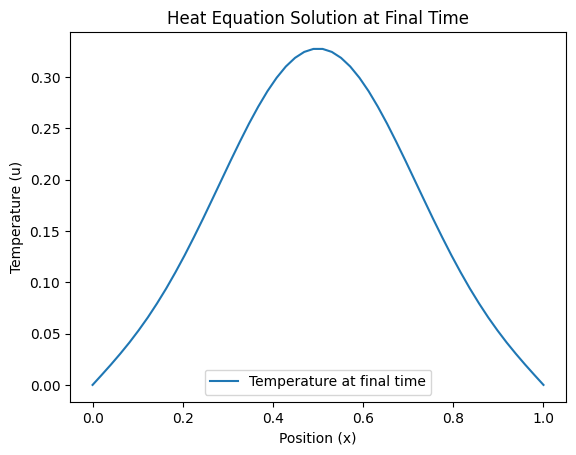

Solution saved to 'heat_equation_solution_solver.npy'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define parameters
L = 1.0       # Length of the rod
Nx = 50       # Number of spatial points
dx = L / Nx   # Space step
T = 0.2       # Total time
Nt = 201     # Number of time steps
dt = T / Nt   # Time step
alpha = 0.1  # Thermal diffusivity

# Stability condition (for explicit scheme)
s = alpha * dt / dx**2
if s > 0.5:
    print("Warning: Stability condition violated! Reduce dt or increase dx.")

# Initial condition: Gaussian pulse
x = np.linspace(0, L, Nx)
u0 = np.exp(-100 * (x - L/2)**2)  # Gaussian initial profile

# Boundary conditions (Dirichlet)
u0[0] = 0
u0[-1] = 0

# Function for the right-hand side of the PDE
def heat_eq(t, u):
    u = u.reshape((Nx,))
    du_dt = np.zeros_like(u)
    for i in range(1, Nx - 1):
        du_dt[i] = alpha * (u[i-1] - 2*u[i] + u[i+1]) / dx**2
    return du_dt

# Solve the PDE using solve_ivp
solution = solve_ivp(heat_eq, [0, T], u0, t_eval=np.linspace(0, T, Nt), method='RK45')

# Reshape the solution to match the time and space dimensions
u = solution.y

# Plot the temperature profile at the final time
plt.plot(x, u[:, -1], label="Temperature at final time")
plt.xlabel("Position (x)")
plt.ylabel("Temperature (u)")
plt.title("Heat Equation Solution at Final Time")
plt.legend()
plt.show()

# Save the full solution for later analysis
np.save('heat_equation_solution_solver.npy', u)

print("Solution saved to 'heat_equation_solution_solver.npy'")


In [ ]:
u.shape

(50, 201)

In [ ]:
from scipy.stats import skewnorm

noise = skewnorm.rvs(a=1, scale=0.5, size=u.shape)
u += noise

AttributeError: shape

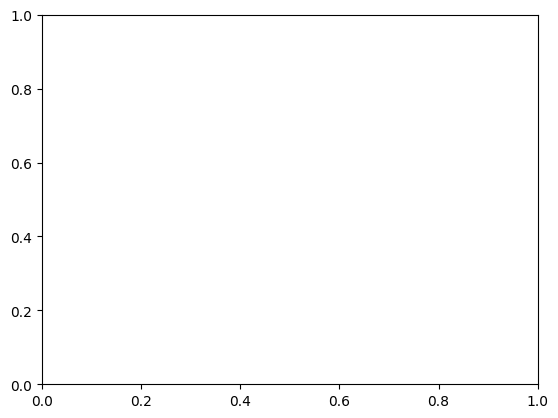

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm
import h5py
def visualize_burgers(xcrd, data, path):
    """
    This function animates the Burgers equation

    Args:
    path : path to the desired file
    param: PDE parameter of the data shard to be visualized
    """
    fig, ax = plt.subplots()
    ims = []

    for i in tqdm(range(data.shape[0])):
        if i == 0:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        else:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        ims.append([im[0]])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save(path, writer=writer)
    plt.close(fig)
visualize_burgers(x, solution, "a.gif")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.loss = nn.MSELoss()
        self.alpha = nn.Parameter(torch.tensor([0.1], requires_grad=True).to("cuda"))
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def loss_fn(self, x, u):
        u_pred = self.forward(x)
        return self.loss(u_pred, u)

    def residual_loss(self, xtrain, fhat):
        x = xtrain[:, 0]
        t = xtrain[:, 1]
        g = xtrain.clone()
        g.requires_grad = True
        u_pred = self.forward(g)
        u_x_t = torch.autograd.grad(
            u_pred, g, torch.ones_like(u_pred), create_graph=True
        )[0]
        u_x, u_t = u_x_t[:, 0], u_x_t[:, 1]
        u_xx = torch.autograd.grad(u_x, g, torch.ones_like(u_x), create_graph=True)[0][
            :, 0
        ]
        residual = u_t - self.alpha * u_xx
        return self.loss(residual, fhat)

    def total_loss(self, xtrain, utrain, fhat):
        return self.loss_fn(xtrain, utrain) + self.residual_loss(xtrain, fhat)

    def train_model(self, xtrain, utrain, epochs=1000):
        fhat = torch.zeros(xtrain.shape[0], 1, device="cuda")
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss = self.total_loss(xtrain, utrain, fhat)
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Loss {loss.item()}, alpha {self.alpha.item()}")



model = PINN(input_size=2, hidden_size=20, output_size=1).to("cuda")
print(model)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=20, bias=True)
    (19): Tanh()
    (20): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss): MSELoss()
)


In [ ]:
t = np.linspace(0, 0.2, 201)
X, T = np.meshgrid(x, t)
u = u.T
X.shape, T.shape, u.shape

((201, 50), (201, 50), (50, 201))

In [ ]:
xtrue = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
idx = np.random.choice(201*50, 5000, replace=False)
xtrain = xtrue[idx, :]
utrain = u.flatten()[idx][:, None]
xtrain.shape, utrain.shape

((5000, 2), (5000, 1))

In [ ]:
device = torch.device("cuda")
Xtrain = torch.tensor(xtrain, dtype=torch.float32).to(device)
Xtrue = torch.tensor(xtrue, dtype=torch.float32).to(device)
Utrain = torch.tensor(utrain, dtype=torch.float32).to(device)
utrue = u.flatten()[:, None]
utrue = torch.tensor(utrue, dtype=torch.float32).to(device)
Xtrain.shape, Xtrue.shape, Utrain.shape, utrue.shape

(torch.Size([5000, 2]),
 torch.Size([10050, 2]),
 torch.Size([5000, 1]),
 torch.Size([10050, 1]))

In [ ]:
model = PINN(input_size=2, hidden_size=20, output_size=1).to("cuda")
model.train_model(Xtrain, Utrain, epochs=10000)

  0%|          | 16/10000 [00:00<02:13, 74.66it/s]

Epoch 0, Loss 0.4220414161682129, alpha 0.09912527352571487


 10%|█         | 1015/10000 [00:13<01:51, 80.45it/s]

Epoch 1000, Loss 0.21855303645133972, alpha -0.15700776875019073


 20%|██        | 2008/10000 [00:25<01:39, 80.54it/s]

Epoch 2000, Loss 0.21573840081691742, alpha -1.107985258102417


 30%|███       | 3011/10000 [00:38<01:31, 76.07it/s]

Epoch 3000, Loss 0.21393151581287384, alpha -1.1754122972488403


 40%|████      | 4012/10000 [00:52<01:33, 63.89it/s]

Epoch 4000, Loss 0.21304816007614136, alpha -1.241059422492981


 50%|█████     | 5007/10000 [01:05<01:18, 63.85it/s]

Epoch 5000, Loss 0.21234063804149628, alpha -1.3107256889343262


 51%|█████▏    | 5130/10000 [01:07<01:04, 75.71it/s]

In [ ]:
model.alpha.item()

0.23954850435256958